In [1]:
# DATA WRANGLING
import numpy as np 
import pandas as pd
import re
from collections import Counter

# DATA VISUALISATION
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from matplotlib_venn_wordcloud import venn2_wordcloud

# NLP
from bertopic import BERTopic
import spacy
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from textblob import TextBlob


# LOAD SPACY
nlp = spacy.load('en_core_web_trf')
nlp.max_length=2000000

In [2]:
df = pd.read_csv('raw data/sustainable time.csv')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def clean_df(df: pd.DataFrame):
    """
    Returns
    --------
    Cleansed pd.DataFrame

    Function drops any queries which are null and replaces null demos with Unknown. 
    Removes punctuation, extra spaces, replaces underscores and words over 14 characters.
    Removes stopwords from the corpus. 
    """
    df = df.dropna(subset=['query']).fillna('Unknown')
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['query'] = (df['query'].str.replace('_', ' ')
                                .str.replace('(\S{14,})|[^\w\s]|  +', '') # Remove words > 14 letters, puncutation, numbers, doublespaces
                                .str.strip()
                                .str.lower()
                                .apply(lambda row: ' '.join([word for word in row.split() if word not in (stopwords)])))
    return df

df = clean_df(df)


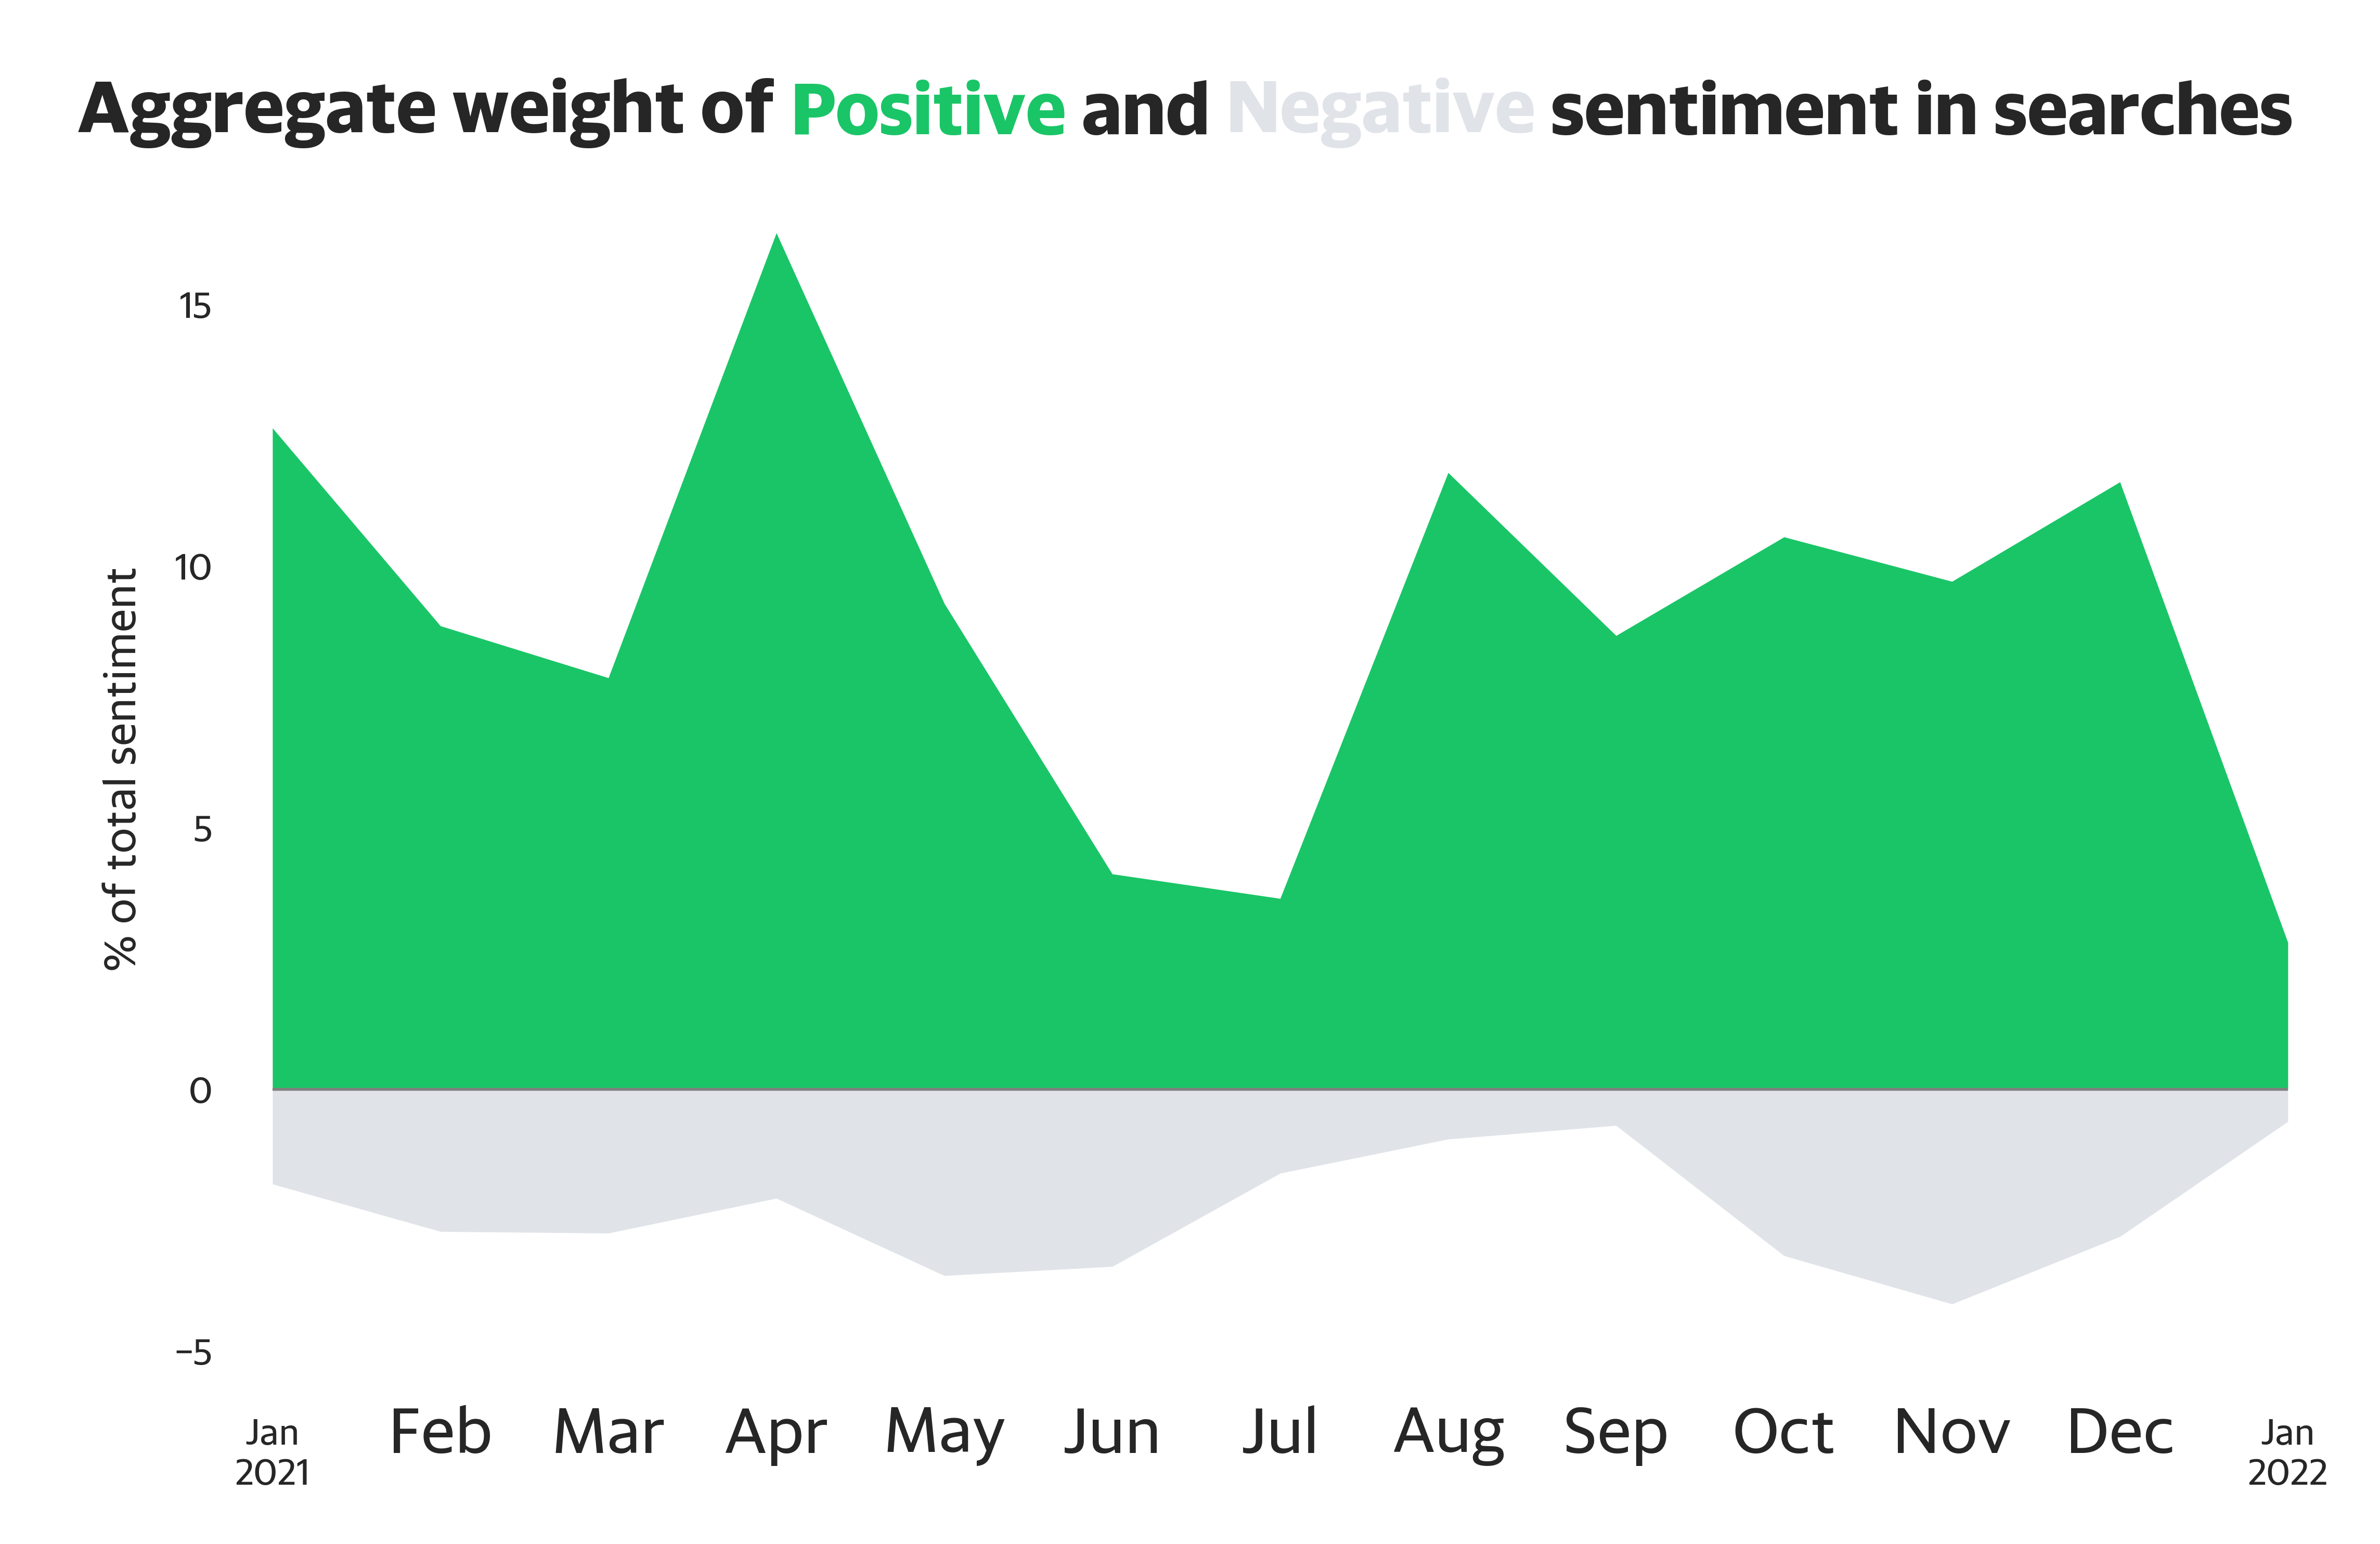

In [356]:
def sentiment_calc(text):
    try:
        return TextBlob(text).polarity
    except:
        return None

def sentiment_plot(df, offset='W-MON'):
    # Assign Sentiment
    df['score'] = df['query'].apply(sentiment_calc)
    df['sentiment'] = pd.cut(df['score'], bins=[-1, -0.2, 0.2, 1],labels=['Negative', 'Neutral', 'Positive'])

    # Shape Data
    df = (df
            .set_index('date')                      
            .sort_index()                           
            .groupby(['sentiment'])['score']           
            .resample(offset)                       
            .sum()                                  
            .reset_index()
            .assign(pct=lambda df_:df_['score'] / df_['score'].sum() * 100)
            .pivot_table(index='date', columns='sentiment', values='pct', aggfunc='sum')
            .drop('Neutral', axis=1))

    # Typography and Colour 
    font = {'family' : 'Yahoo Sans', 'weight':'normal'}
    plt.rc('font', **font)
    sent_colors = {'very Negative':'#E0E4E9', 'Negative':'#E0E4E9', 'Neutral':'Grey', 'Positive':'#1AC567', 'very Positive':'#00873C'}

    # Grid & data
    fig, ax = plt.subplots(figsize=(5,3), dpi=1000)
    df.plot.area(color=sent_colors, legend=False, lw=0, ax=ax)

    # Axes
    ax.set(xlabel="")
    ax.set_ylabel('% of total sentiment', fontsize=6)
    ax.axhline(y=0, color='grey', zorder=10, lw=0.4)
    ax.tick_params('both', labelsize=5)

    # Title
    s = 'Aggregate weight of <Positive> and <Negative> sentiment in searches'
    fig_text(0.05, 0.9, s, fontweight='bold', fontsize=10, va='bottom', highlight_textprops=[{"color": "#1AC567", "fontweight":'bold'},
                                                                        {"color": "#E0E4E9", "fontweight":"bold"}])

    # Aesthetics
    for direction in ['bottom', 'left']:
        ax.spines[direction].set_lw(0.2)
        ax.spines[direction].set_color('grey')
        ax.spines[direction].set_alpha(0.5)
    sns.despine(left=True, bottom=True)



sentiment_plot(df, 'M')




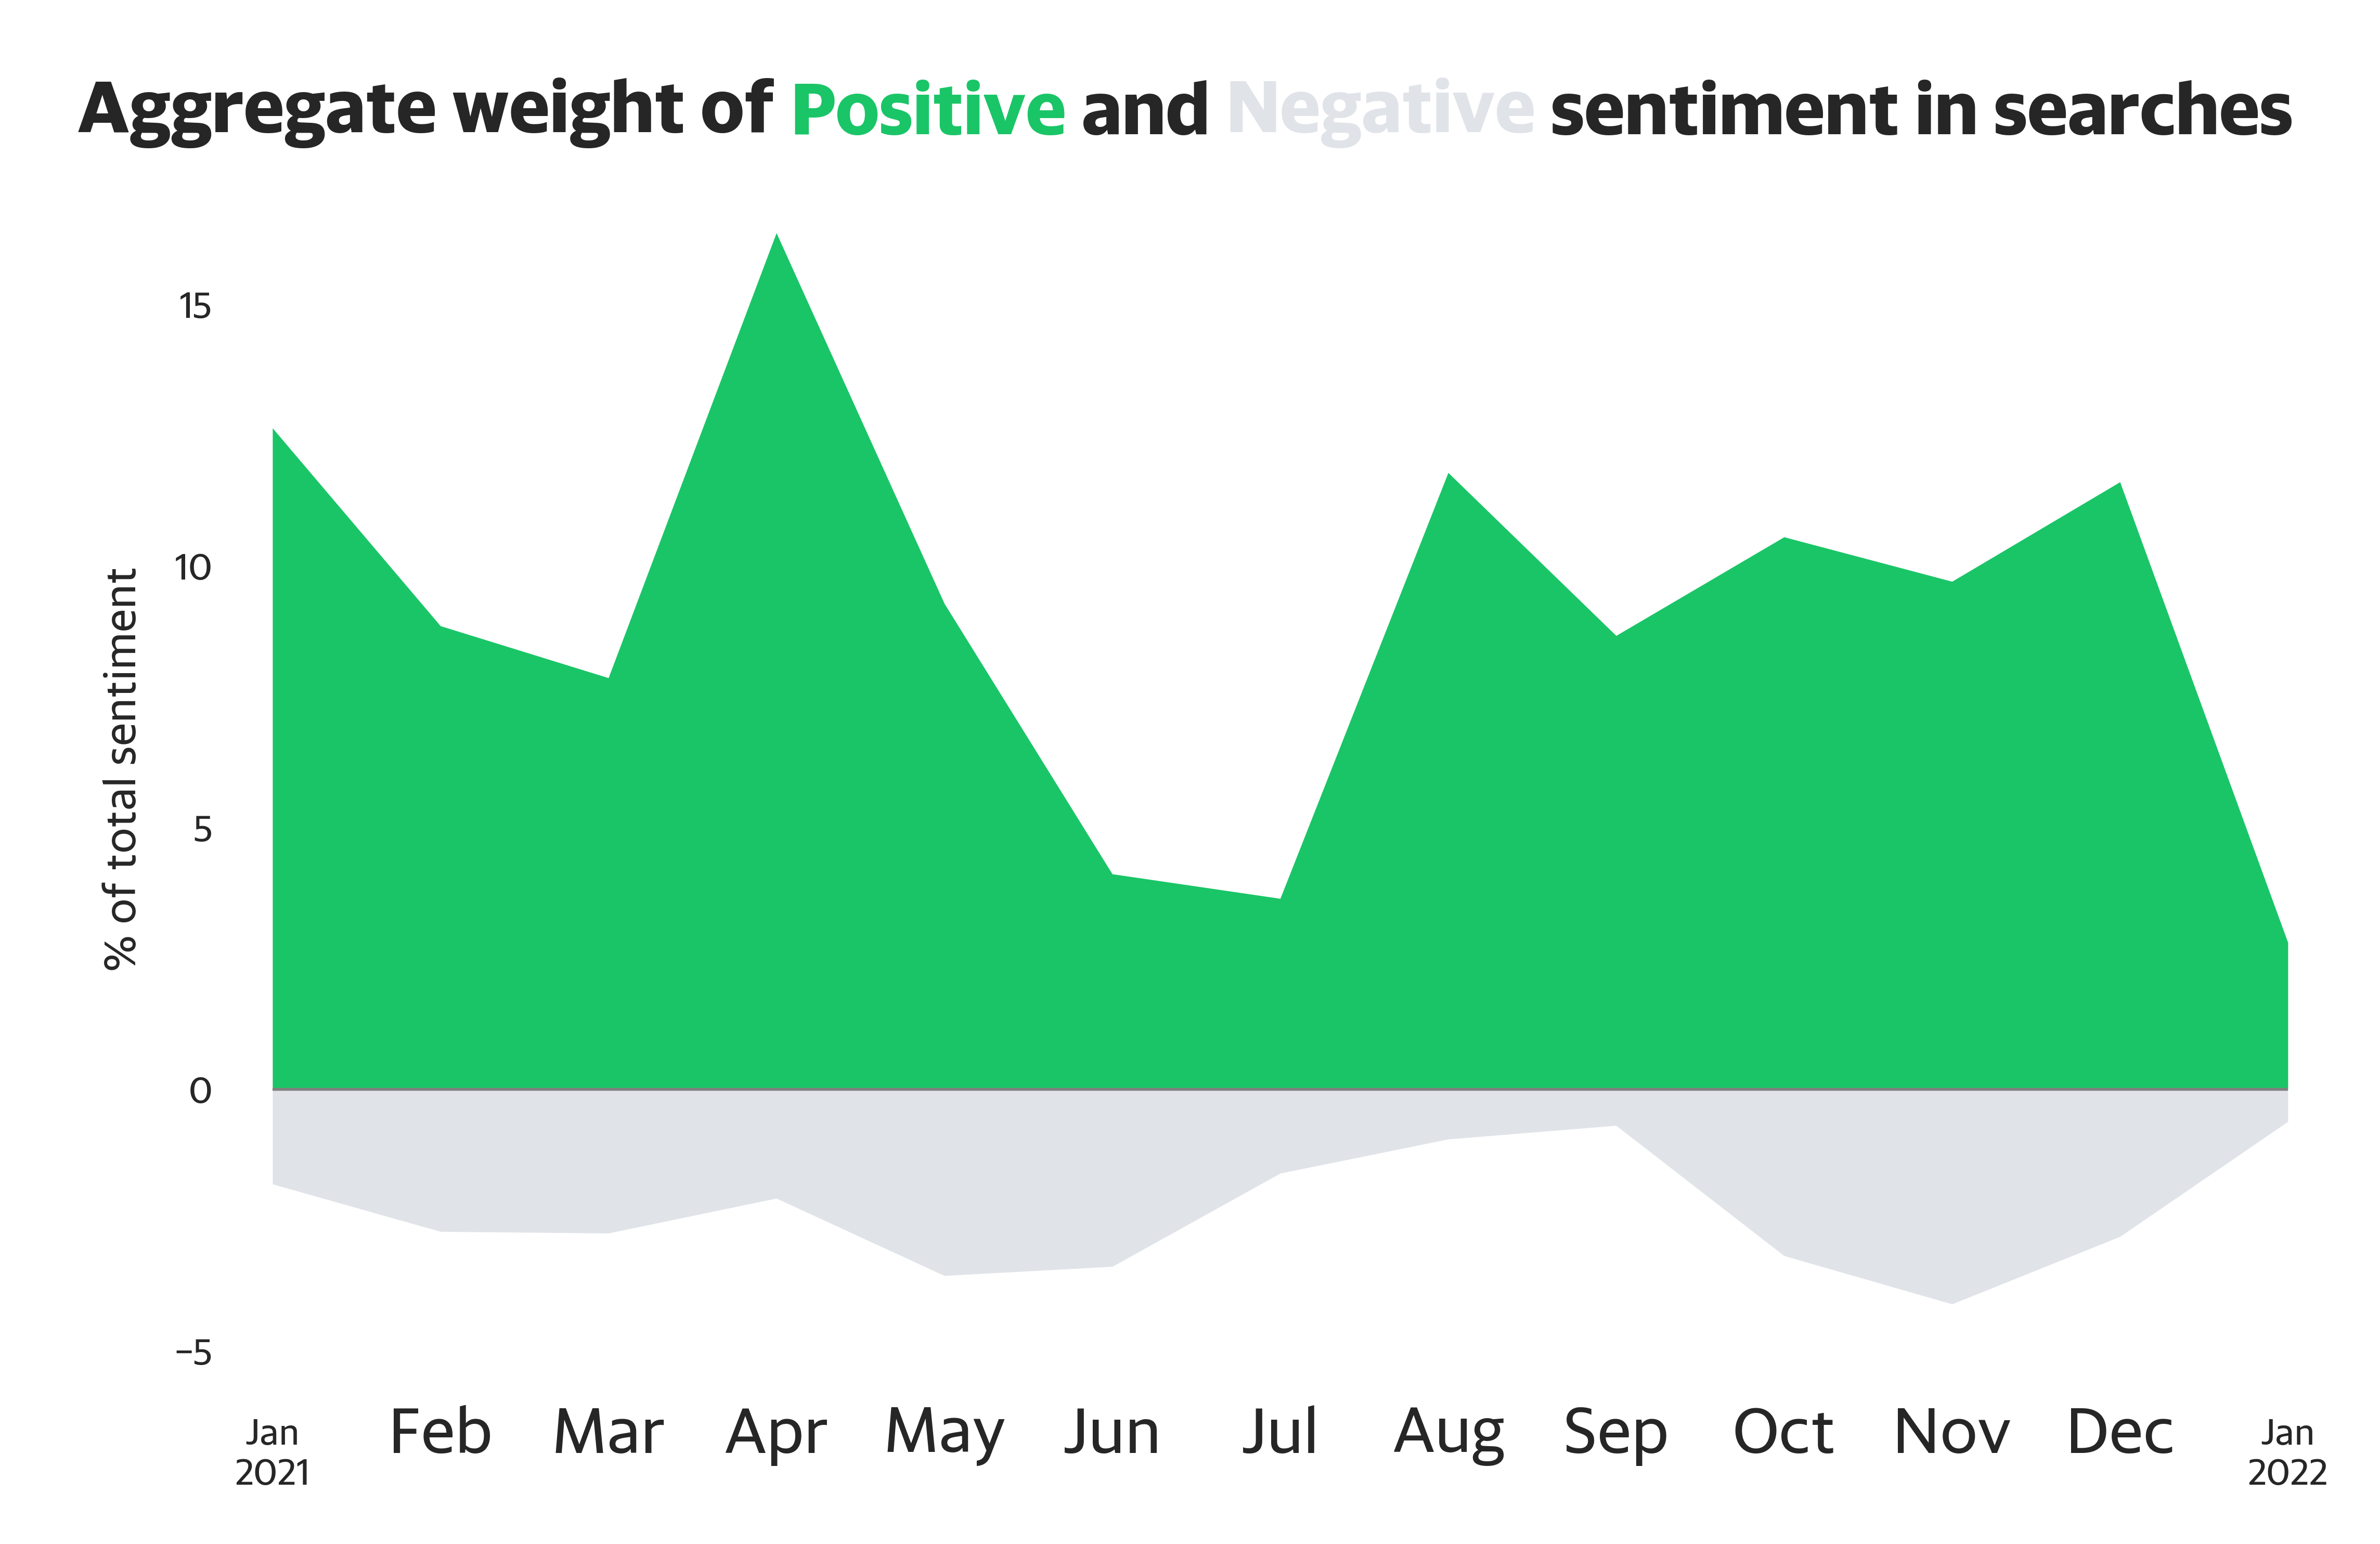

In [346]:
def sentiment_calc(text):
    try:
        return TextBlob(text).polarity
    except:
        return None

def assign_sentiment(df):
    """Simple sentiment - positive or negative"""
    df['score'] = df['query'].apply(sentiment_calc)
    df['sentiment'] = pd.cut(df['score'], bins=[-1, -0.2, 0.2, 1],labels=['Negative', 'Neutral', 'Positive'], )
    return df

def sentiment_plot(df, offset='W-MON'):
    """Creates a weekly summary of sentiment"""
    return (df
            .set_index('date')                      # set date as the index
            .sort_index()                           # make sure dates are sorted chronologically
            .groupby(['sentiment'])['score']        # group dates by sentiment, and display their scores    
            .resample(offset)                      # changes the aggregation to weekly from daily for a smoother chart
            .sum()                                  # sum that weeks worth of sentiment
            .reset_index()
            .assign(pct=lambda df_:df_['score'] / df_['score'].sum() * 100)
            .pivot_table(index='date', columns='sentiment', values='pct', aggfunc='sum')
            .drop('Neutral', axis=1))


df = assign_sentiment(df)
week_sent = sentiment_plot(df, offset='M')


def sentiment_plot(df):
    # Typography and Colour 
    font = {'family' : 'Yahoo Sans', 'weight':'normal'}
    plt.rc('font', **font)
    sent_colors = {'very Negative':'#E0E4E9', 'Negative':'#E0E4E9', 'Neutral':'Grey', 'Positive':'#1AC567', 'very Positive':'#00873C'}

    # Grid & data
    fig, ax = plt.subplots(figsize=(5,3), dpi=1000)
    df.plot.area(color=sent_colors, legend=False, lw=0, ax=ax)

    # Axes
    ax.set(xlabel="")
    ax.set_ylabel('% of total sentiment', fontsize=6)
    ax.axhline(y=0, color='grey', zorder=10, lw=0.4)
    ax.tick_params('both', labelsize=5)

    # Title
    s = 'Aggregate weight of <Positive> and <Negative> sentiment in searches'
    fig_text(0.05, 0.9, s, fontweight='bold', fontsize=10, va='bottom', highlight_textprops=[{"color": "#1AC567", "fontweight":'bold'},
                                                                        {"color": "#E0E4E9", "fontweight":"bold"}])

    # Aesthetics
    for direction in ['bottom', 'left']:
        ax.spines[direction].set_lw(0.2)
        ax.spines[direction].set_color('grey')
        ax.spines[direction].set_alpha(0.5)
    sns.despine(left=True, bottom=True)

    # return fig

sentiment_plot(week_sent)


In [223]:
def weekly_sentiment(df):
    """Creates a weekly summary of sentiment"""
    return (df
            .query('sentiment != "Neutral"')
            .set_index('date')                      # set date as the index
            .sort_index()                           # make sure dates are sorted chronologically
            .groupby(['sentiment'])['score']        # group dates by sentiment, and display their scores    
            .resample('W-MON')                      # changes the aggregation to weekly from daily for a smoother chart
            .sum()                                  # sum that weeks worth of sentiment
            .reset_index()
            .assign(pct=lambda df_:df_['score'] / df_['score'].sum() * 100))

week_sent = weekly_sentiment(df)

In [366]:
df['sentiment'].value_counts(normalize=True).mul(100)

Neutral     90.237591
Positive     6.469066
Negative     3.293343
Name: sentiment, dtype: float64

In [43]:
tokens = nlp(''.join(str(df['query'].tolist())))
entities = [(x.text, x.label_) for x in tokens.ents]


In [44]:
entities = pd.DataFrame(entities).rename(columns={0:"entity", 1:"label"})

In [46]:
(entities
    # .query('label == "ORG"')
    .groupby('entity').count()
    .reset_index()
    .nlargest(50, 'label')
)

,entity,label
35,albaray clothing,8
69,aspiga,8
302,london,8
530,two,5
531,uk,5
552,wells christmas market,5
6,abdeen mustafa omer publishers,4
416,robertson construction,4
537,unilevercom,4
3,abdeen mustafa omer,3


In [79]:
sentences = df['query'].to_list()

aspects = []
for sentence in sentences:
  doc = nlp(sentence)
  descriptive_term = ''
  target = ''
  for token in doc:
    if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
      target = token.text
    if token.pos_ == 'ADJ':
      prepend = ''
      for child in token.children:
        if child.pos_ != 'ADV':
          continue
        prepend += child.text + ' '
      descriptive_term = prepend + token.text
  aspects.append({'aspect': target,
    'description': descriptive_term})

In [129]:
from textblob import TextBlob
for aspect in aspects:
  aspect['sentiment'] = TextBlob(aspect['description']).polarity

df_aspect = pd.DataFrame(aspects)

(df_aspect
.groupby('aspect', as_index=False)
.agg(sentiment=('sentiment', 'mean'), count=('sentiment', 'size'))
.sort_values('count', ascending=False)
.head(50)
.style
.background_gradient(subset='sentiment')
)

,aspect,sentiment,count
0,,0.017937,3970
83,heat,0.146667,15
134,pumps,0.100000,9
173,ways,0.087500,8
16,brands,-0.128571,7
42,companies,0.000000,6
18,business,0.200000,6
13,boots,0.000000,5
114,oil,0.350000,4
133,pump,0.225000,4


In [133]:
df_aspect.query('aspect == "heat"')

,aspect,description,sentiment
1669,heat,,0.0
2131,heat,,0.0
2437,heat,,0.0
2481,heat,,0.0
2604,heat,good,0.7
2645,heat,,0.0
2879,heat,electric,0.0
2979,heat,,0.0
3050,heat,good,0.7
3058,heat,,0.0


In [120]:
(df_aspect
.groupby('aspect', as_index=False)
.sum()
.sort_values('sentiment', ascending=False)
)

,aspect,sentiment
0,,71.208628
83,heat,2.200000
114,oil,1.400000
18,business,1.200000
72,fish,1.000000
...,...,...
156,students,-0.300000
43,conditions,-0.300000
154,steps,-0.400000
8,avocado,-0.700000


In [74]:
aspects = pd.DataFrame(aspects)
aspects.dropna(subset=['aspect'])
aspects.query('aspect != ""')[['aspect', 'description']].value_counts().head(50)

aspect         description             
heat                                       9
pumps                                      7
boots                                      5
business       economically sustainable    4
ways           sustainable                 4
heat           good                        4
companies      sustainable                 4
brands                                     3
clients        overall                     3
choice         identifiable                3
covid          sustainable                 3
item           sustainable                 2
cafes          sustainable                 2
tourists       unsustainable               2
metric                                     2
consumers                                  2
systems        central                     2
item           sustanible                  2
challenges     sustainable                 2
funds          double                      2
steps          green                       2
ships          

In [77]:
aspects.tolist()

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [78]:
from textblob import TextBlob
for aspect in aspects:
  aspect['sentiment'] = TextBlob(aspect['description']).sentiment


TypeError: string indices must be integers

# SENTIMENT ANALYSIS

In [96]:
nlp.add_pipe("spacytextblob")
nlp.pipe_names

['transformer',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'spacytextblob']

In [137]:
def sentiment_calc(text):
    try:
        return TextBlob(text).polarity
    except:
        return None

def assign_sentiment(df):
    df['score'] = df['query'].apply(sentiment_calc)
    df['sentiment'] = pd.cut(df['score'], bins=5,labels=['very Negative','Negative','Neutral','Positive','very Positive'])
    return df

assign_sentiment(df)

,query,date,age,gender,nlp,entities,score,sentiment
0,womens oversized tracksuit sustainable,20210102,Under 35,Female,"(womens, oversized, tracksuit, sustainable)",,0.0,Neutral
1,acey clothes,20210102,55+,Male,"(acey, clothes)",,0.0,Neutral
2,livinteriors,20210102,35-54,Female,(livinteriors),,0.0,Neutral
3,translation sustainable planet french,20210102,55+,Female,"(translation, sustainable, planet, french)",,0.0,Neutral
4,flip top glass water bottles stoppers,20210102,55+,Male,"(flip, top, glass, water, bottles, stoppers)",,0.5,Positive
...,...,...,...,...,...,...,...,...
4247,buzzstation whitehaven,20220113,Unknown,Unknown,"(buzzstation, whitehaven)",,0.0,Neutral
4248,timber buildings southampton,20220113,55+,Unknown,"(timber, buildings, southampton)",,0.0,Neutral
4249,grocery,20220113,35-54,Unknown,(grocery),,0.0,Neutral
4250,defra,20220113,Unknown,Male,(defra),,0.0,Neutral


In [ ]:
# Colour format 
def purple(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h = 267 # 0 - 360
    s = 99 # 0 - 100
    l = random_state.randint(50, 80) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)
    
def create_wordcloud(df):
    # Aesthetics
    font = {'family' : 'Yahoo Sans', 'weight' : 'bold'}
    plt.rc('font', **font)

    # Create spaCy document and tokenise 
    doc = nlp(" ".join(df_words.query('age in @age_selection and gender in @gender_selection')[searches].to_list()))
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and token.pos_ in parts_option]
    tokens = Counter(tokens)

    # Instantiate wordcloud object
    wc = WordCloud(background_color='white', 
               color_func=purple,
               collocations=True,
               max_words=200,
               width=1200, height=1000, prefer_horizontal=0.9)

    wc = wc.generate_from_frequencies(tokens)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    st.pyplot(fig)




# Create copy of dataframe for use in wordcloud
df_words = df.copy()

# Demographic Selection
ages = df[age].unique().tolist()
genders = df[gender].unique().tolist()
parts = ['ADJ', 'NOUN', 'VERB', 'PRON']

# User Selectable Configuration
with st.form(key='wordkey'):
    age_selection = st.multiselect('Select Age', ages, default=ages)
    gender_selection = st.multiselect('Select Gender', genders, default=genders)
    parts_option = st.multiselect(label='Select Part of Speech', options= parts, default=['NOUN'])
    st.form_submit_button('Submit Choices') 






clean_words = {key:value for key, value in Counter(tokens).items()}





date
2021-01-02     9
2021-01-03    13
2021-01-04    13
2021-01-05    23
2021-01-06    13
              ..
2022-01-09    10
2022-01-10    12
2022-01-11    16
2022-01-12     8
2022-01-13    20
Length: 376, dtype: int64

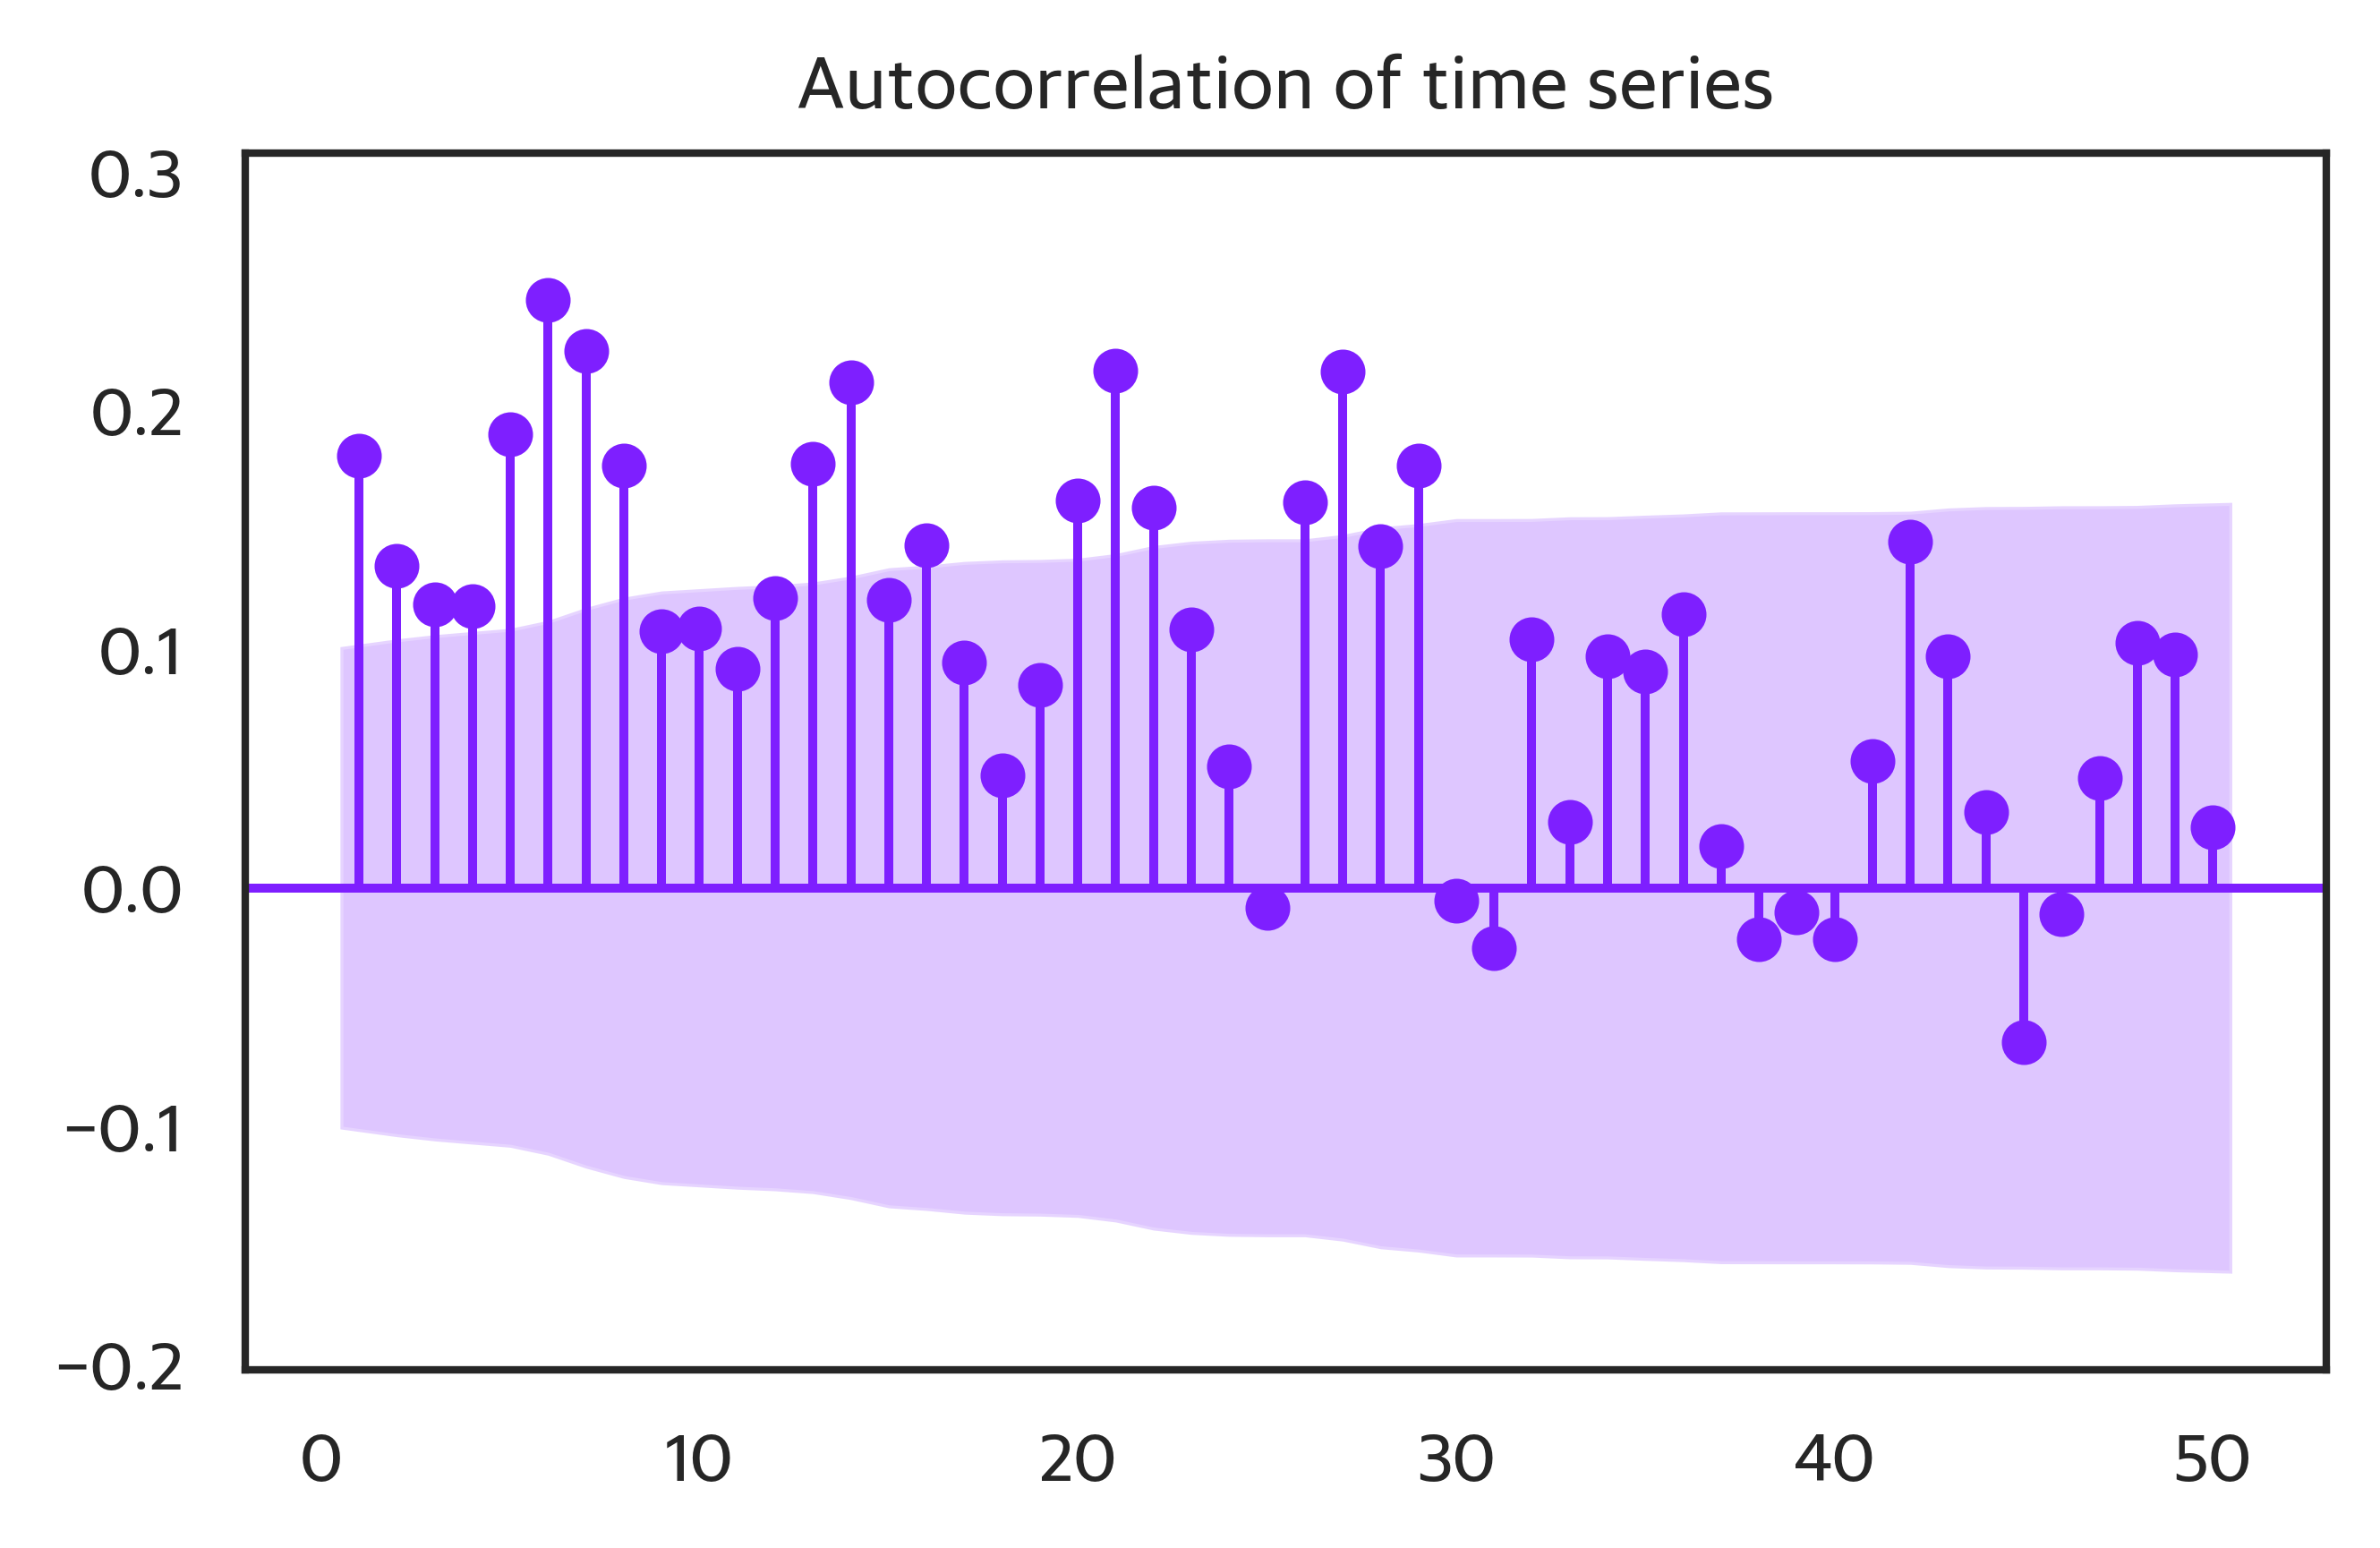

In [386]:
from statsmodels.graphics.tsaplots import plot_acf


fig, ax = plt.subplots(figsize=(5,3), dpi=600)
daily_queries = df.groupby('date').size()
plot_acf(x=daily_queries, lags=50, ax=ax, use_vlines=True, missing='conservative', zero=False, auto_ylims=True, title='Autocorrelation of time series')

plt.show()

In [412]:
import dataframe_image as dfi
# df_questions = df[df['query'].str.replace('_', ' ').str.replace(r'(co.uk|www.|http://|\d| amp|&amp|(\S{14,}))', '').str.strip().str.replace('  ', ' ').str.lower()]

thequestions = (df
                .query('query.str.contains("^do |^how|what|when|why|where|^is ")', engine='python')
                .groupby('query', as_index=False)
                .size()
                .sort_values('size', ascending=False)
                .head(40)
                .style.set_properties(**{
                    'margin': 25,
                    'font-size': 0.9,
                    'font-family': 'Yahoo Sans',
                    'text-align':'left',
                    'title-align':'left',
                    'font-weight':500,
                    'max-width':'700px'})
                .set_table_styles(
                [{'selector': 'th',  
                    'props': [('background-color', 'white'),
                            ('text-align', 'left'),
                            ('font-size', 24),
                            ('color', '#6001D2')]},
                    {'selector':'tr:nth-child(odd)', 
                            'props':[('background-color','white')]}
                        ] )
                .hide_index()
                .hide_columns(['size']))

dfi.export(thequestions, 'questions.png')



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[0131/094149.611976:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/6g/gsjhpkk93mz3b19jjsz5vk340000gq/T/: Operation not permitted (1)
[0131/094149.613070:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0131/094149.614958:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/6g/gsjhpkk93mz3b19jjsz5vk340000gq/T/: Operation not permitted (1)
[0131/094150.775580:INFO:headless_shell.cc(653)] Written to file /var/folders/6g/gsjhpkk93mz3b19jjsz5vk340000gq/T/tmpf5zvktsz/temp.png.


In [587]:
date = 'date'
from prophet import Prophet

def research_dates(df):
    return (df[date].dt.date.min().strftime('%-d %b %Y'), df[date].dt.date.max().strftime('%-d %b %Y'))

def country_codes():
    codes = (pd.read_csv('raw data/country_codes.csv')
                   .assign(Code=lambda df: df['ISO code'].str.split('/').str[0])
                   .drop('ISO code', axis='columns'))
        
    return codes

def is_spring_summer(ds):
    dt = pd.to_datetime(ds)
    return dt.quarter == 2 | dt.quarter == 3

holidays = pd.read_csv('raw data/custom_holidays.csv')
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%d/%m/%Y')


df_prophet = (df
                .groupby(date, as_index=False).size()
                .rename({date:'ds', 'size':'y'}, axis='columns')
                .sort_values('ds')
                .assign(autumn_winter=lambda df:~df['ds'].apply(is_spring_summer),
                        spring_summer=lambda df:df['ds'].apply(is_spring_summer)))

# Instantiate
m = Prophet(holidays=holidays, weekly_seasonality=False)

# Configure & Fit 
m.add_country_holidays(country_name='UK') 
m.add_seasonality(name='weekly_springsummer', period=7, fourier_order=3, condition_name='spring_summer')
m.add_seasonality(name='weekly_autumnwinter', period=7, fourier_order=3, condition_name='autumn_winter')
m.fit(df_prophet)

# Predict
future = m.make_future_dataframe(periods=30)
future['autumn_winter'] = ~future['ds'].apply(is_spring_summer)
future['spring_summer'] = future['ds'].apply(is_spring_summer)

forecast = m.predict(future)
cols = ['ds', 'holidays', 'weekly_springsummer', 'weekly_autumnwinter', 'yhat']
df_seasonality = (pd.concat([forecast[cols], df_prophet['y']], axis='columns')
                    .dropna()
                    .assign(holiday_impact=lambda df: df['holidays'] / df['y'],
                                      ss_weeklyimpact=lambda df: df['weekly_springsummer'] / df['y'],
                                      aw_weeklyimpact=lambda df: df['weekly_autumnwinter'] / df['y'],
                                      dayofweek=lambda df: df['ds'].dt.day_name(),
                                      weekday=lambda df: df['ds'].dt.dayofweek))


def holiday_cleanup(ser):
    return (ser.str.replace('[England/Wales/Northern Ireland]', '', regex=False)
               .str.replace(' [Northern Ireland]', '', regex=False)
    )


df_holidays = (m.construct_holiday_dataframe(df_seasonality['ds'])
                .assign(holiday=lambda df: holiday_cleanup(df['holiday']))
                .set_index('ds'))

# holiday_impact = pd.concat([df_seasonality.set_index('ds'), df_holidays], axis='columns', join='inner').reset_index()

cols = ['ds', 'holidays', 'holiday_impact', 'yhat', 'y']

holiday_impact = (pd.concat([df_seasonality[cols].set_index('ds'), df_holidays], axis='columns')
                    .reset_index()
                    .query('holidays != 0')
                    .dropna(subset=['holidays'])
                    .fillna(''))

scot = holiday_impact['holiday'].str.contains("Scotland")
holiday_impact = holiday_impact.loc[~scot]

research_start, research_end = research_dates(df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.2817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       546.623   0.000189393       83.2377      0.5816      0.5816      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       546.671    0.00017181        74.303   1.962e-06       0.001      174  LS failed, Hessian reset 
     133       546.679    1.3963e-07       71.3514   1.973e-09       0.001      252  LS failed, Hessian reset 
     199       546.719   9.69171e-06       80.8244      0.4427      0.4427      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       546.723   2.75821e-05       76.0571   3.617e-07       0.001      401  LS failed, Hessian reset 
     299       546.753   2.75266e-06       58.9962      0.7776      0.7776      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

In [307]:
research_start = df[date].dt.date.min().strftime('%-d %b %Y')
research_end = df[date].dt.date.max().strftime('%-d %b %Y')


'2 Jan 2021'

In [584]:
def holiday_cleanup(ser):
    return (ser.str.replace('[England/Wales/Northern Ireland]', '', regex=False)
               .str.replace(' [Northern Ireland]', '', regex=False)
    )

def hol_impact(df):
    df_holidays = (pd.read_csv('raw data/custom_holidays.csv')
                        .assign(ds=lambda df: pd.to_datetime(df['ds']))
                        .filter(['ds', 'holiday'], axis='columns')
                        .append(m.construct_holiday_dataframe(df_seasonality['ds']))
                        .assign(holiday=lambda df: holiday_cleanup(df['holiday']))
                        .set_index('ds'))

    holiday_impact = pd.concat([df_seasonality.set_index('ds'), df_holidays], axis='columns', join='inner').reset_index()

    cols = ['ds', 'holidays', 'holiday_impact', 'yhat', 'y']

    holiday_impact = (pd.concat([df_seasonality[cols].set_index('ds'), df_holidays], axis='columns')
                    .reset_index()
                    .query('holidays != 0')
                    .dropna(subset=['holidays'])
                    .fillna(''))

    scot = holiday_impact['holiday'].str.contains("Scotland")
    holiday_impact = holiday_impact.loc[~scot]

    return holiday_impact



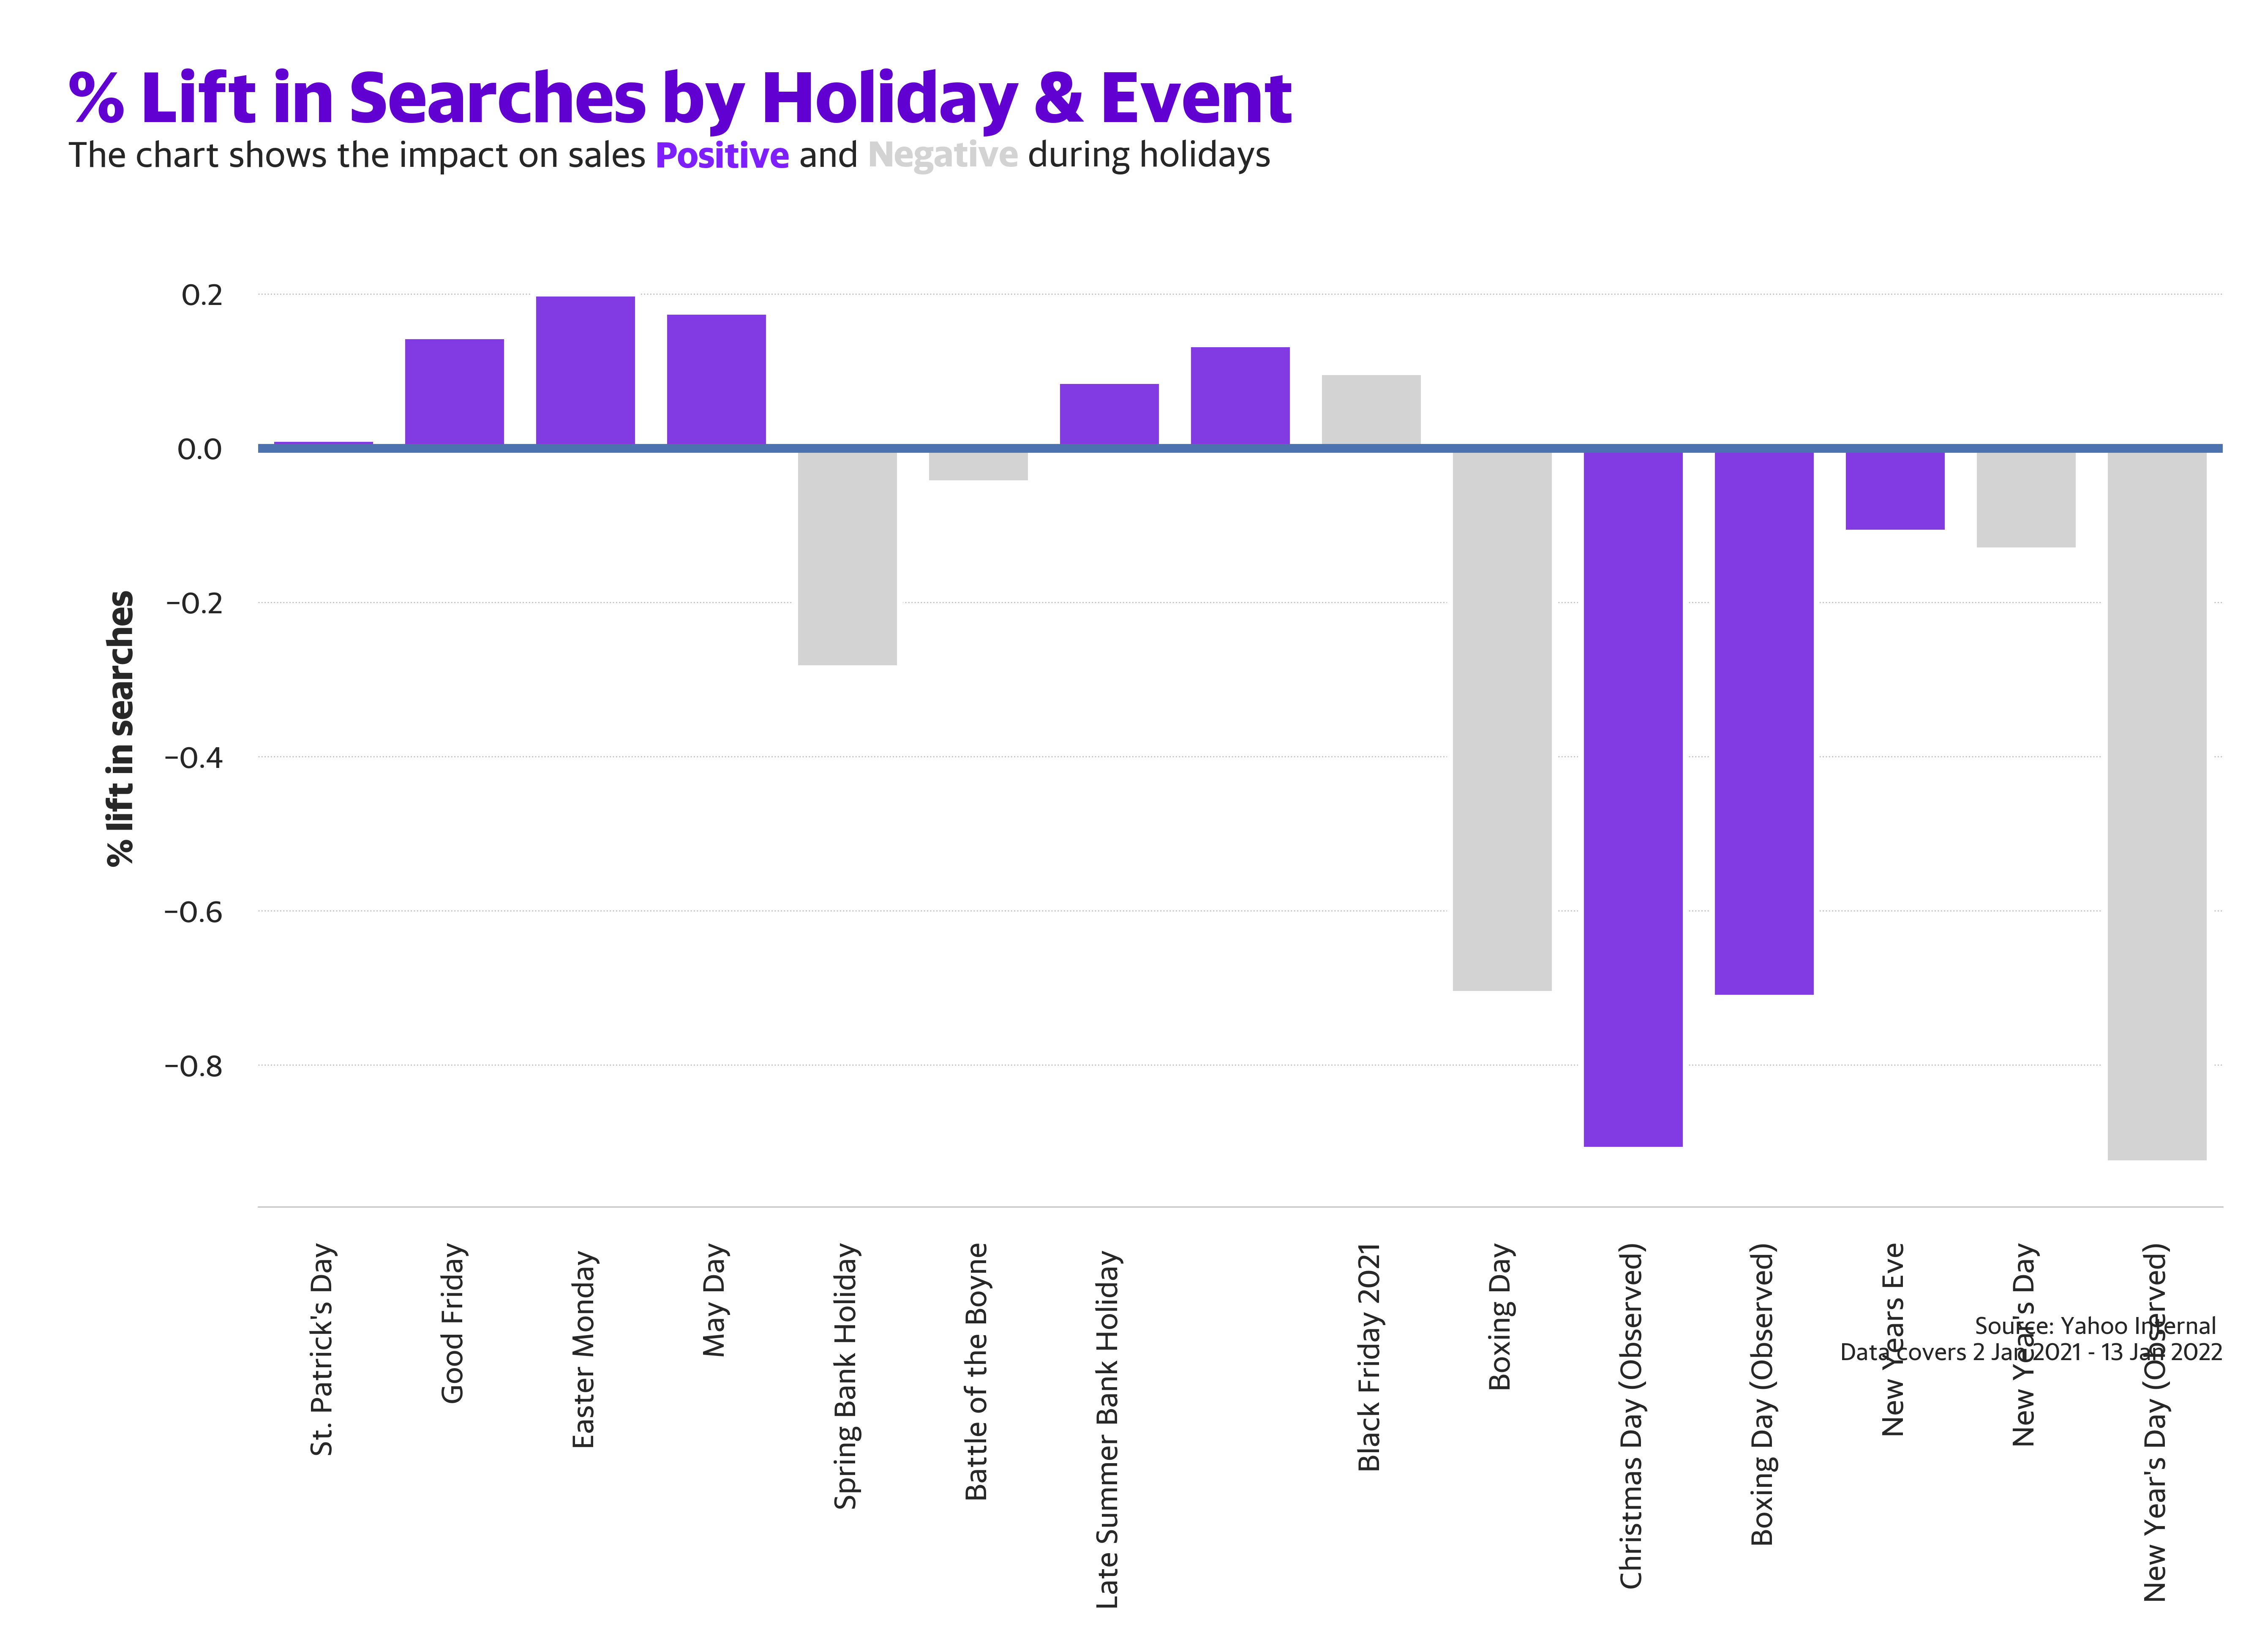

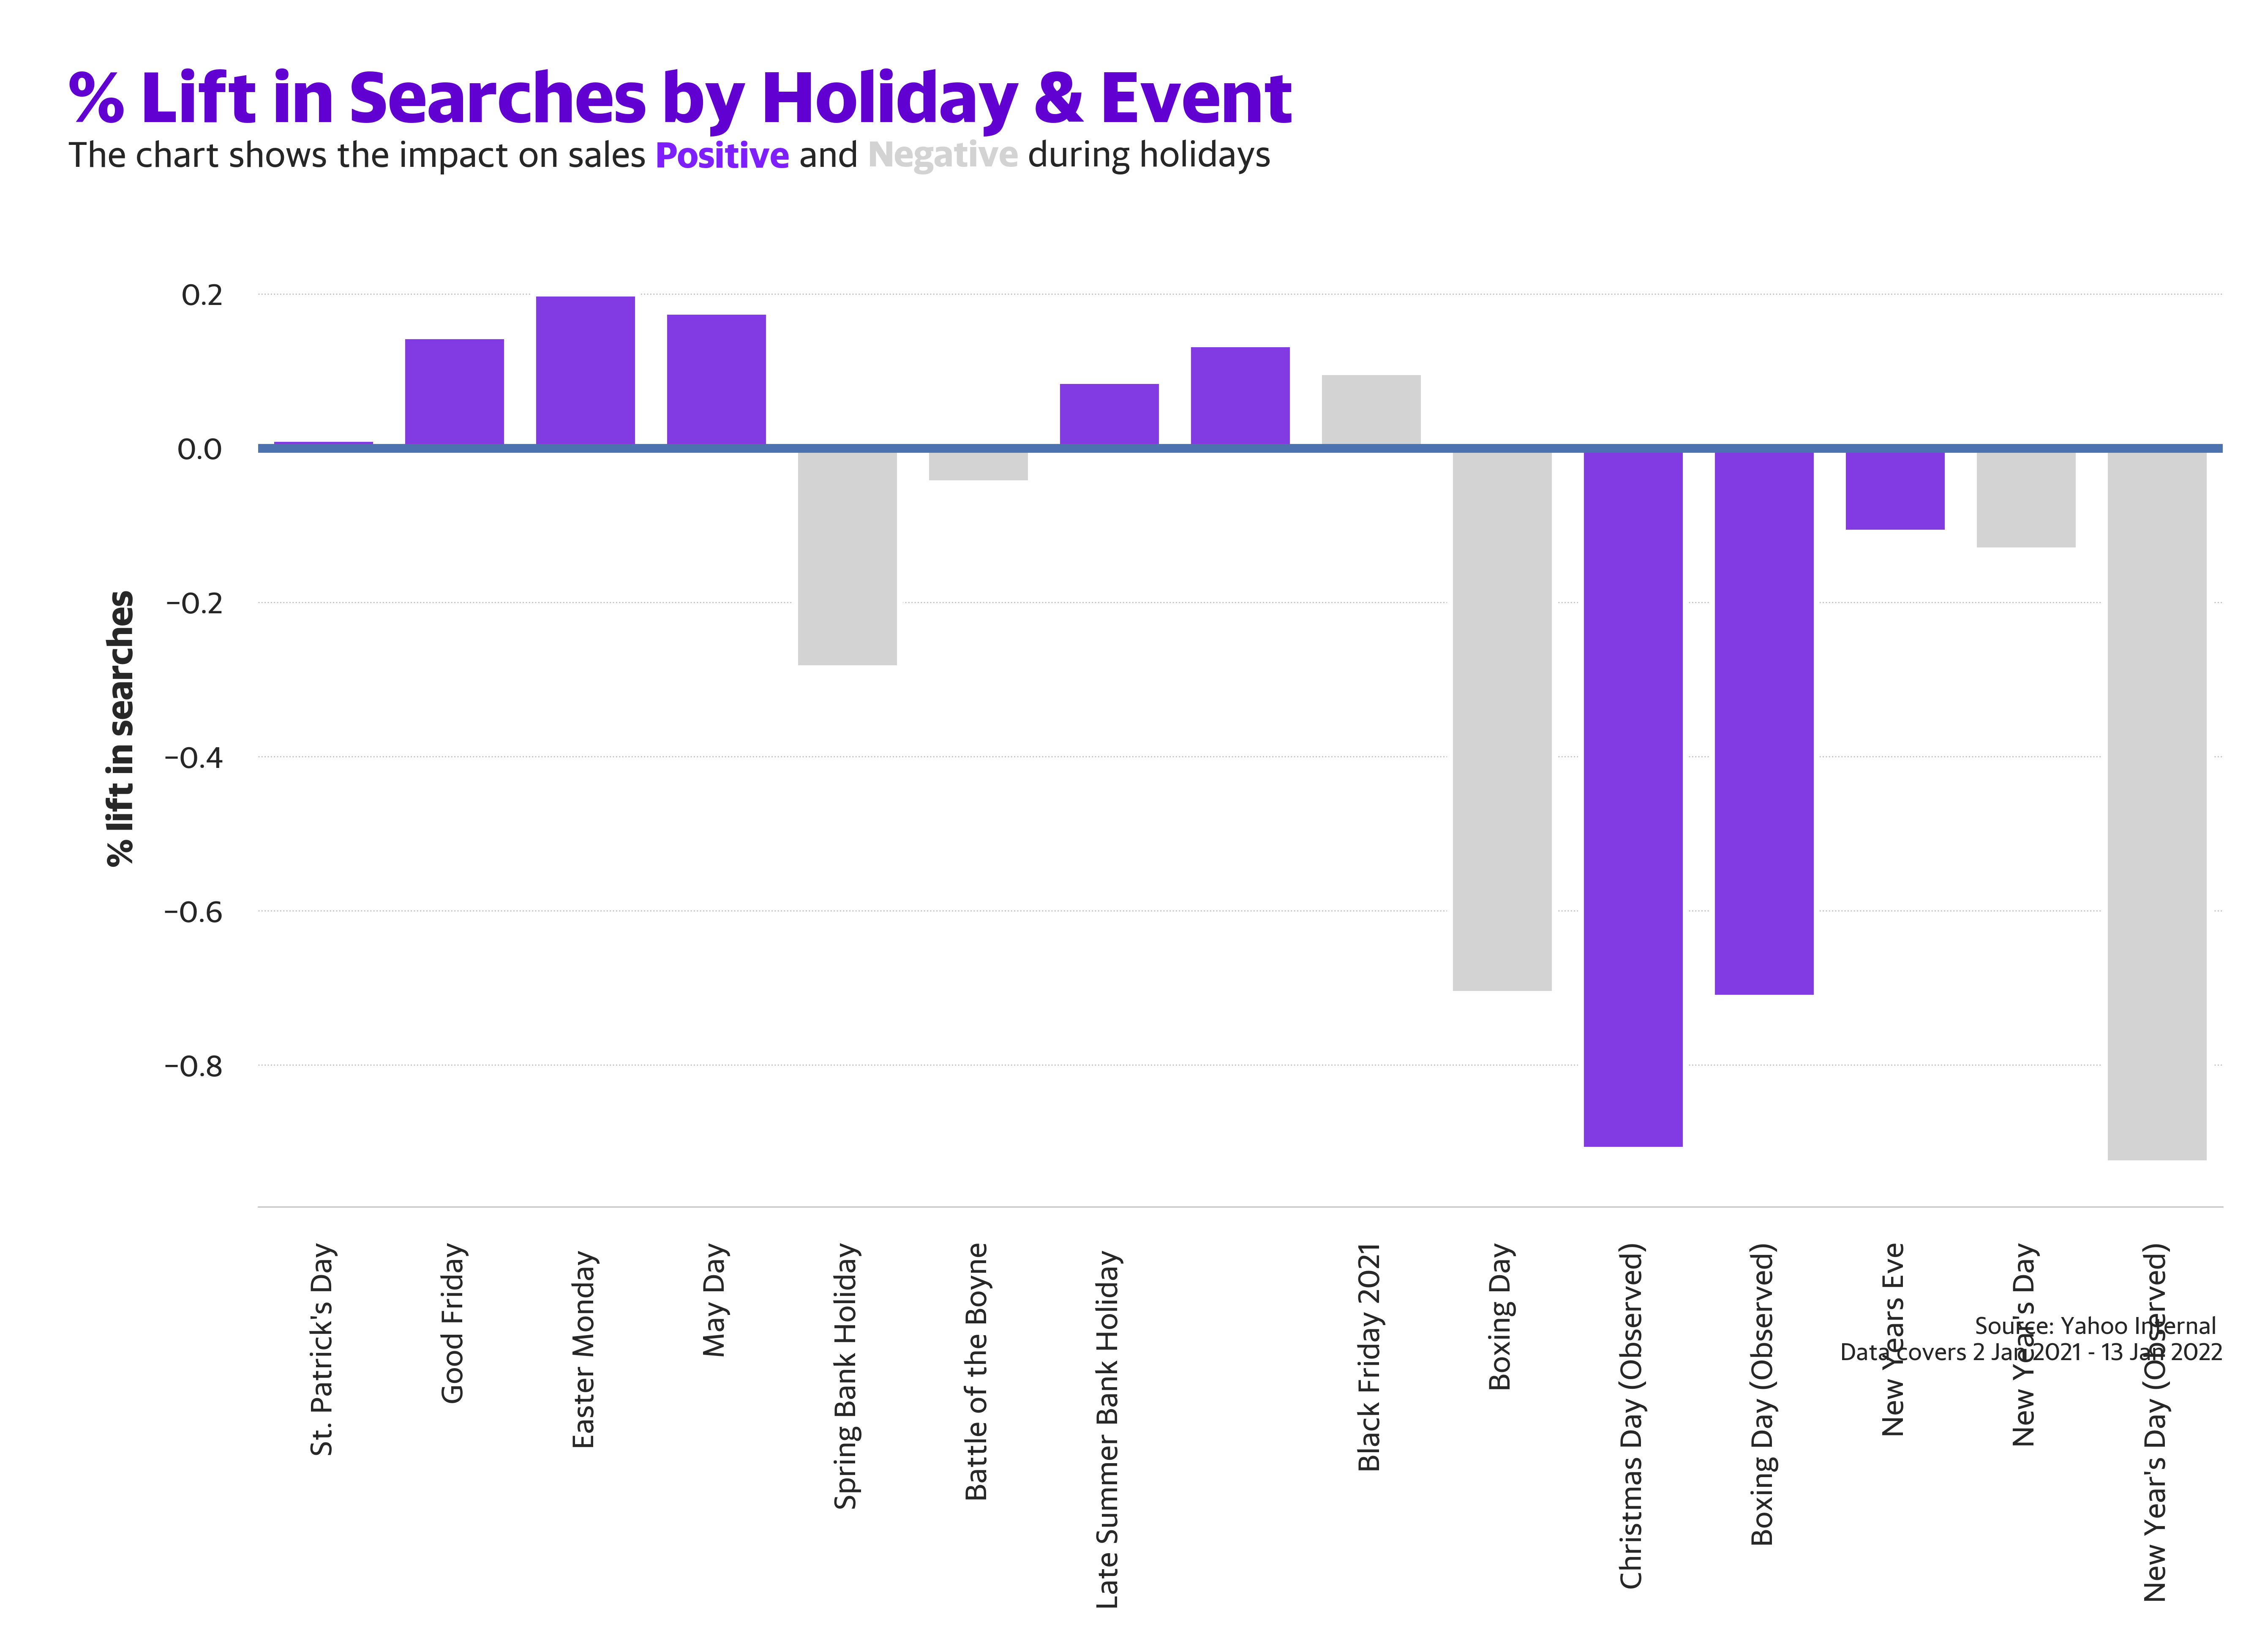

In [592]:
def holiday_impact_plot(df):
    fig, ax = plt.subplots(figsize=(6,3), dpi=1000)
    colors = ['#7E1FFF' if c >= 0 else 'lightgrey' for c in holiday_impact.holidays]

    sns.set(font='Yahoo Sans', style='white')
    sns.barplot(x='holiday', y='holiday_impact', data=holiday_impact, palette=colors, ci=None)

    # Labels
    ax.set_xlabel('')
    ax.set_ylabel('% lift in searches', fontsize=6, fontweight='bold')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, left=False, labelsize=5, pad=0, rotation=90)
    ax.tick_params(axis='y', which='both', bottom=False, top=False, left=False, labelsize=5, pad=0)

    # Spines
    sns.despine(left=True, bottom=False)

    for direction in ['bottom', 'left']:
        ax.spines[direction].set_lw(0.2)
        ax.spines[direction].set_color('grey')
        ax.spines[direction].set_alpha(0.5)
    
    ax.grid(which='major', axis='y', dashes=(1,3), zorder=4, color='gray', ls=':', alpha=0.5, lw=0.2)
    ax.grid(axis='x', visible=False)
    ax.axhline(0)
    # Title
    s = '% Lift in Searches by Holiday & Event'
    s2 = 'The chart shows the impact on sales <Positive> and <Negative> during holidays' 
    fig_text(0.05, 0.92, s, fontweight='bold', fontsize=12, va='bottom',  color='#6001D2')

    fig_text(0.05, 0.89, s2, fontsize=6, va='bottom', highlight_textprops=[{"color": "#7E1FFF", "fontweight":'bold'},
                                                                            {"color": "lightgrey", "fontweight":"bold"}])

    # Adjust axes positions to fit commentary
    pos1 = ax.get_position() # get the original position 
    pos2 = [pos1.x0, pos1.y0 - 0.05,  pos1.width, pos1.height]
    ax.set_position(pos2)

    # Source
    fig.supxlabel(f'Source: Yahoo Internal \nData covers {research_start} - {research_end}', fontsize=4, x=0.9, y=-0.05, ha='right')
    
    plt.savefig('holiday_impact.png', dpi=1000, transparent=True)

    return fig


holiday_impact_plot(holiday_impact)

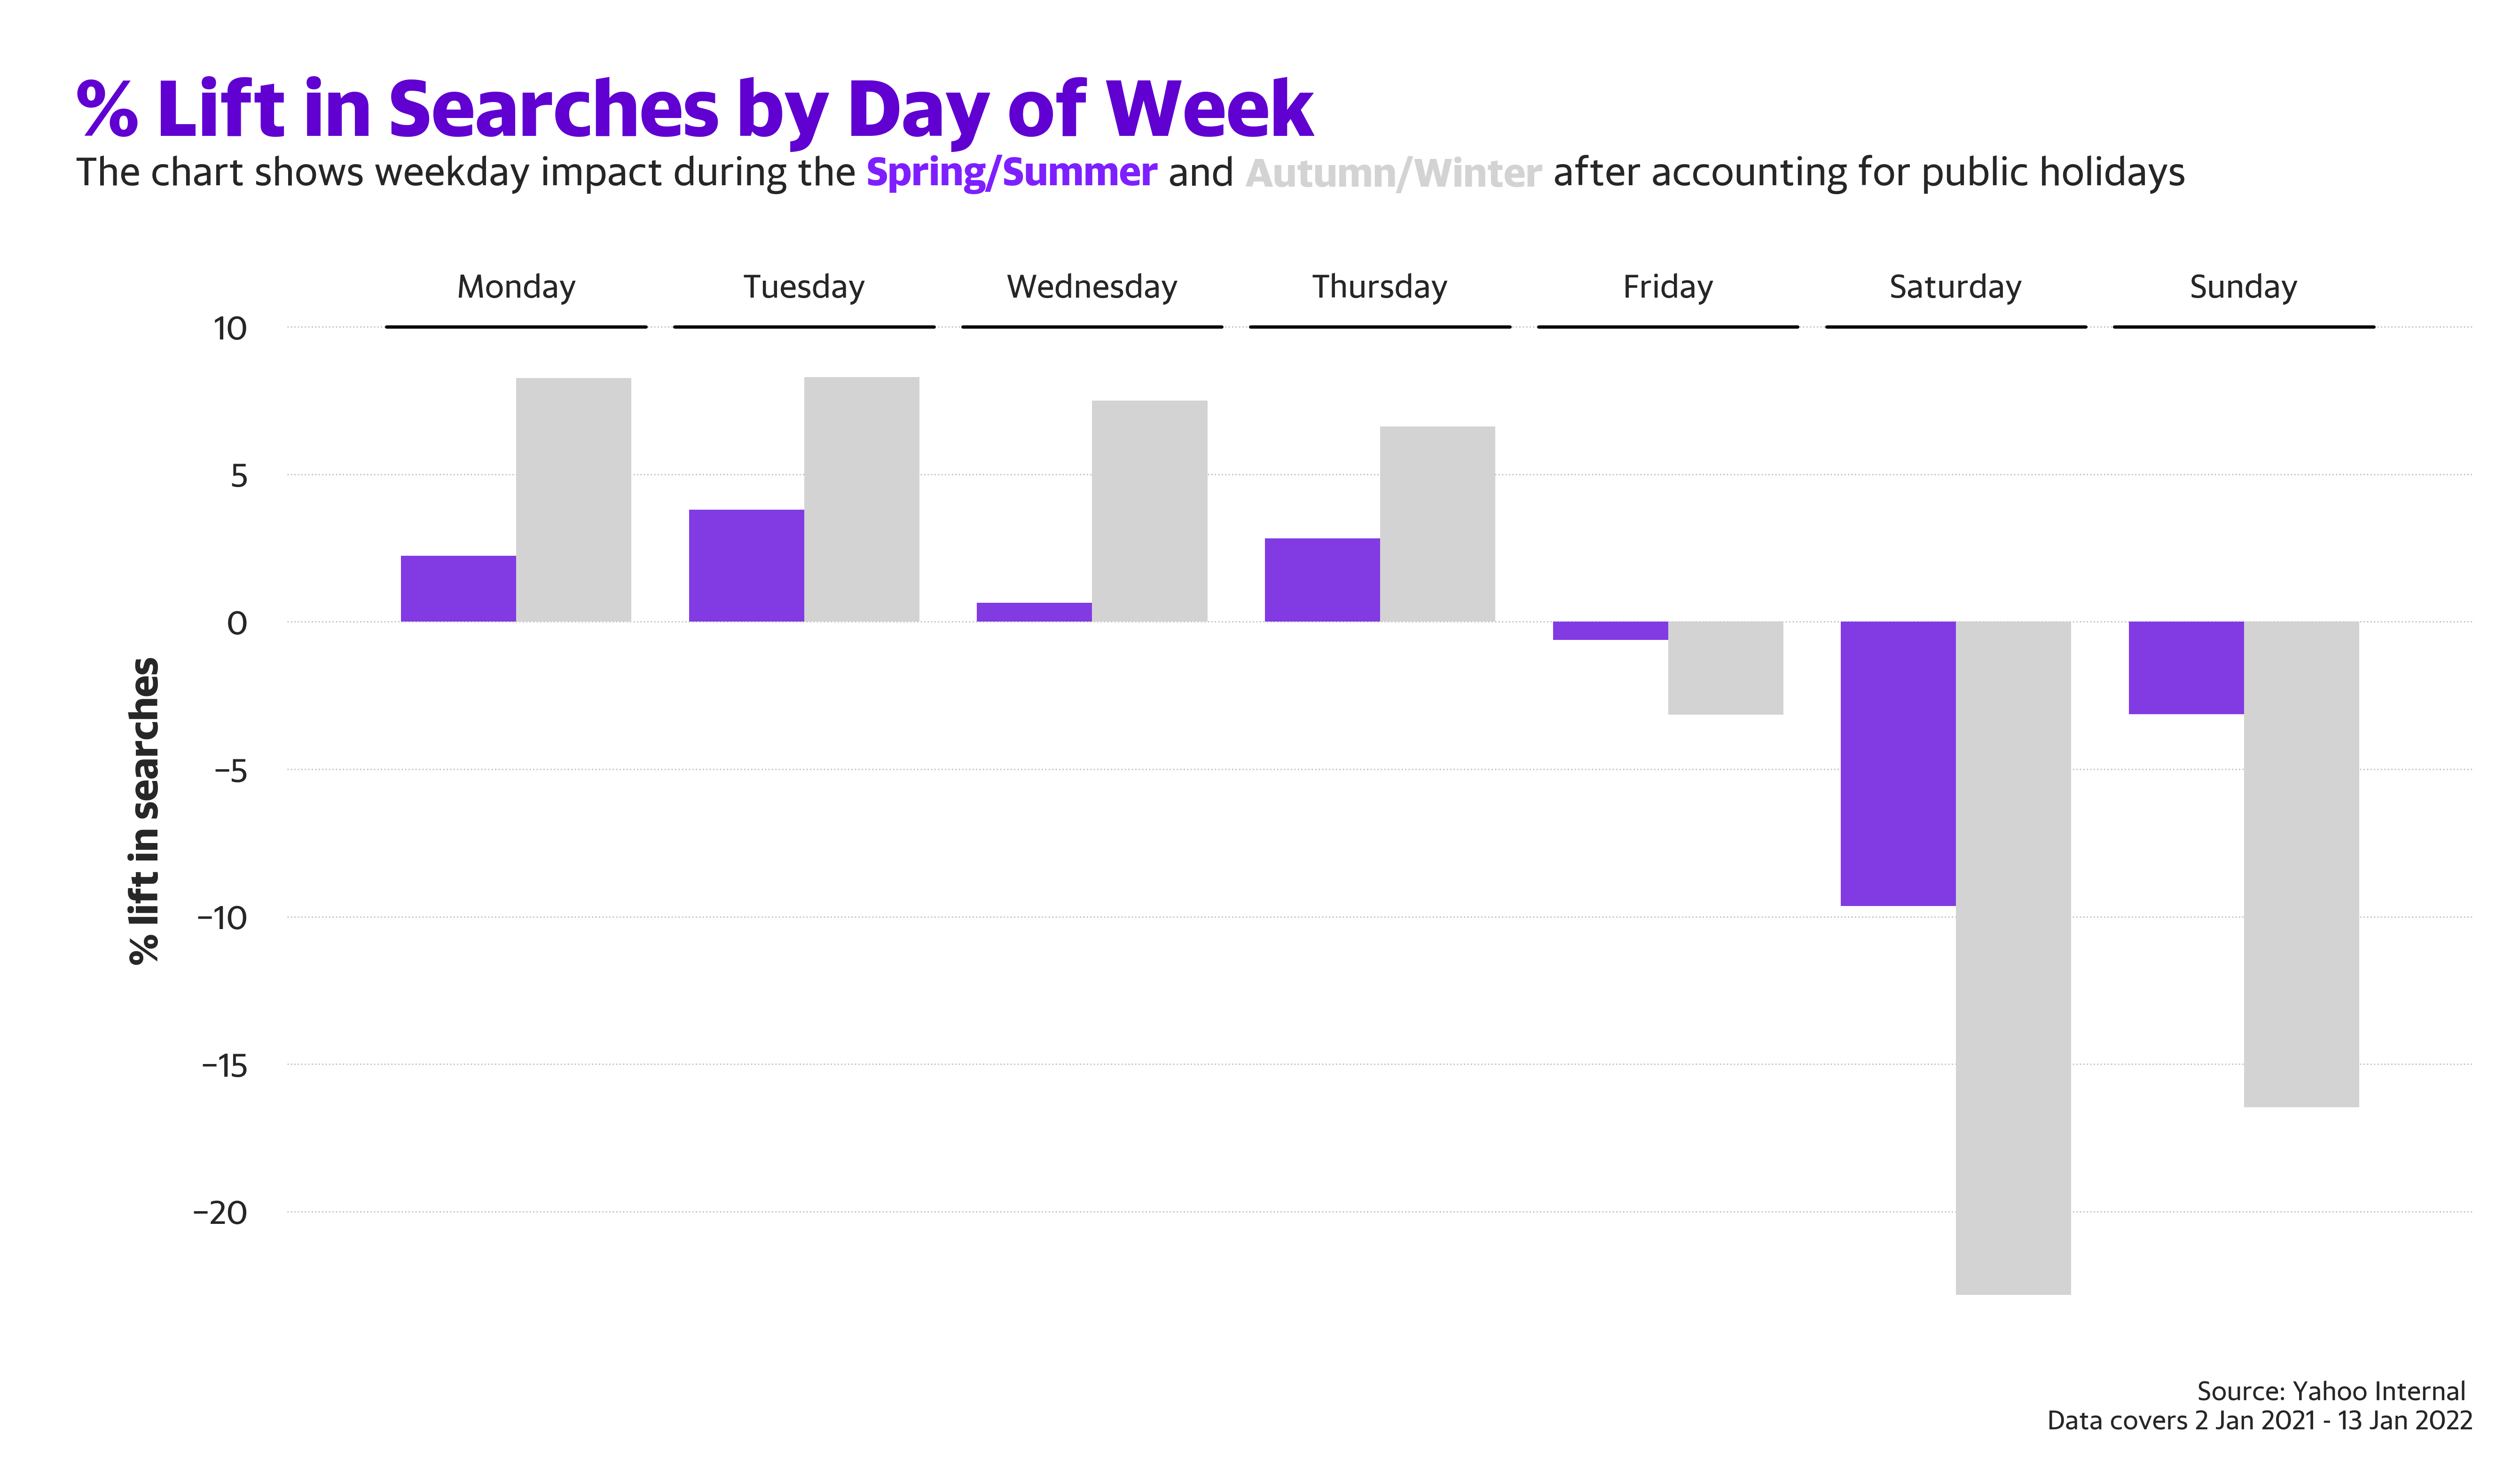

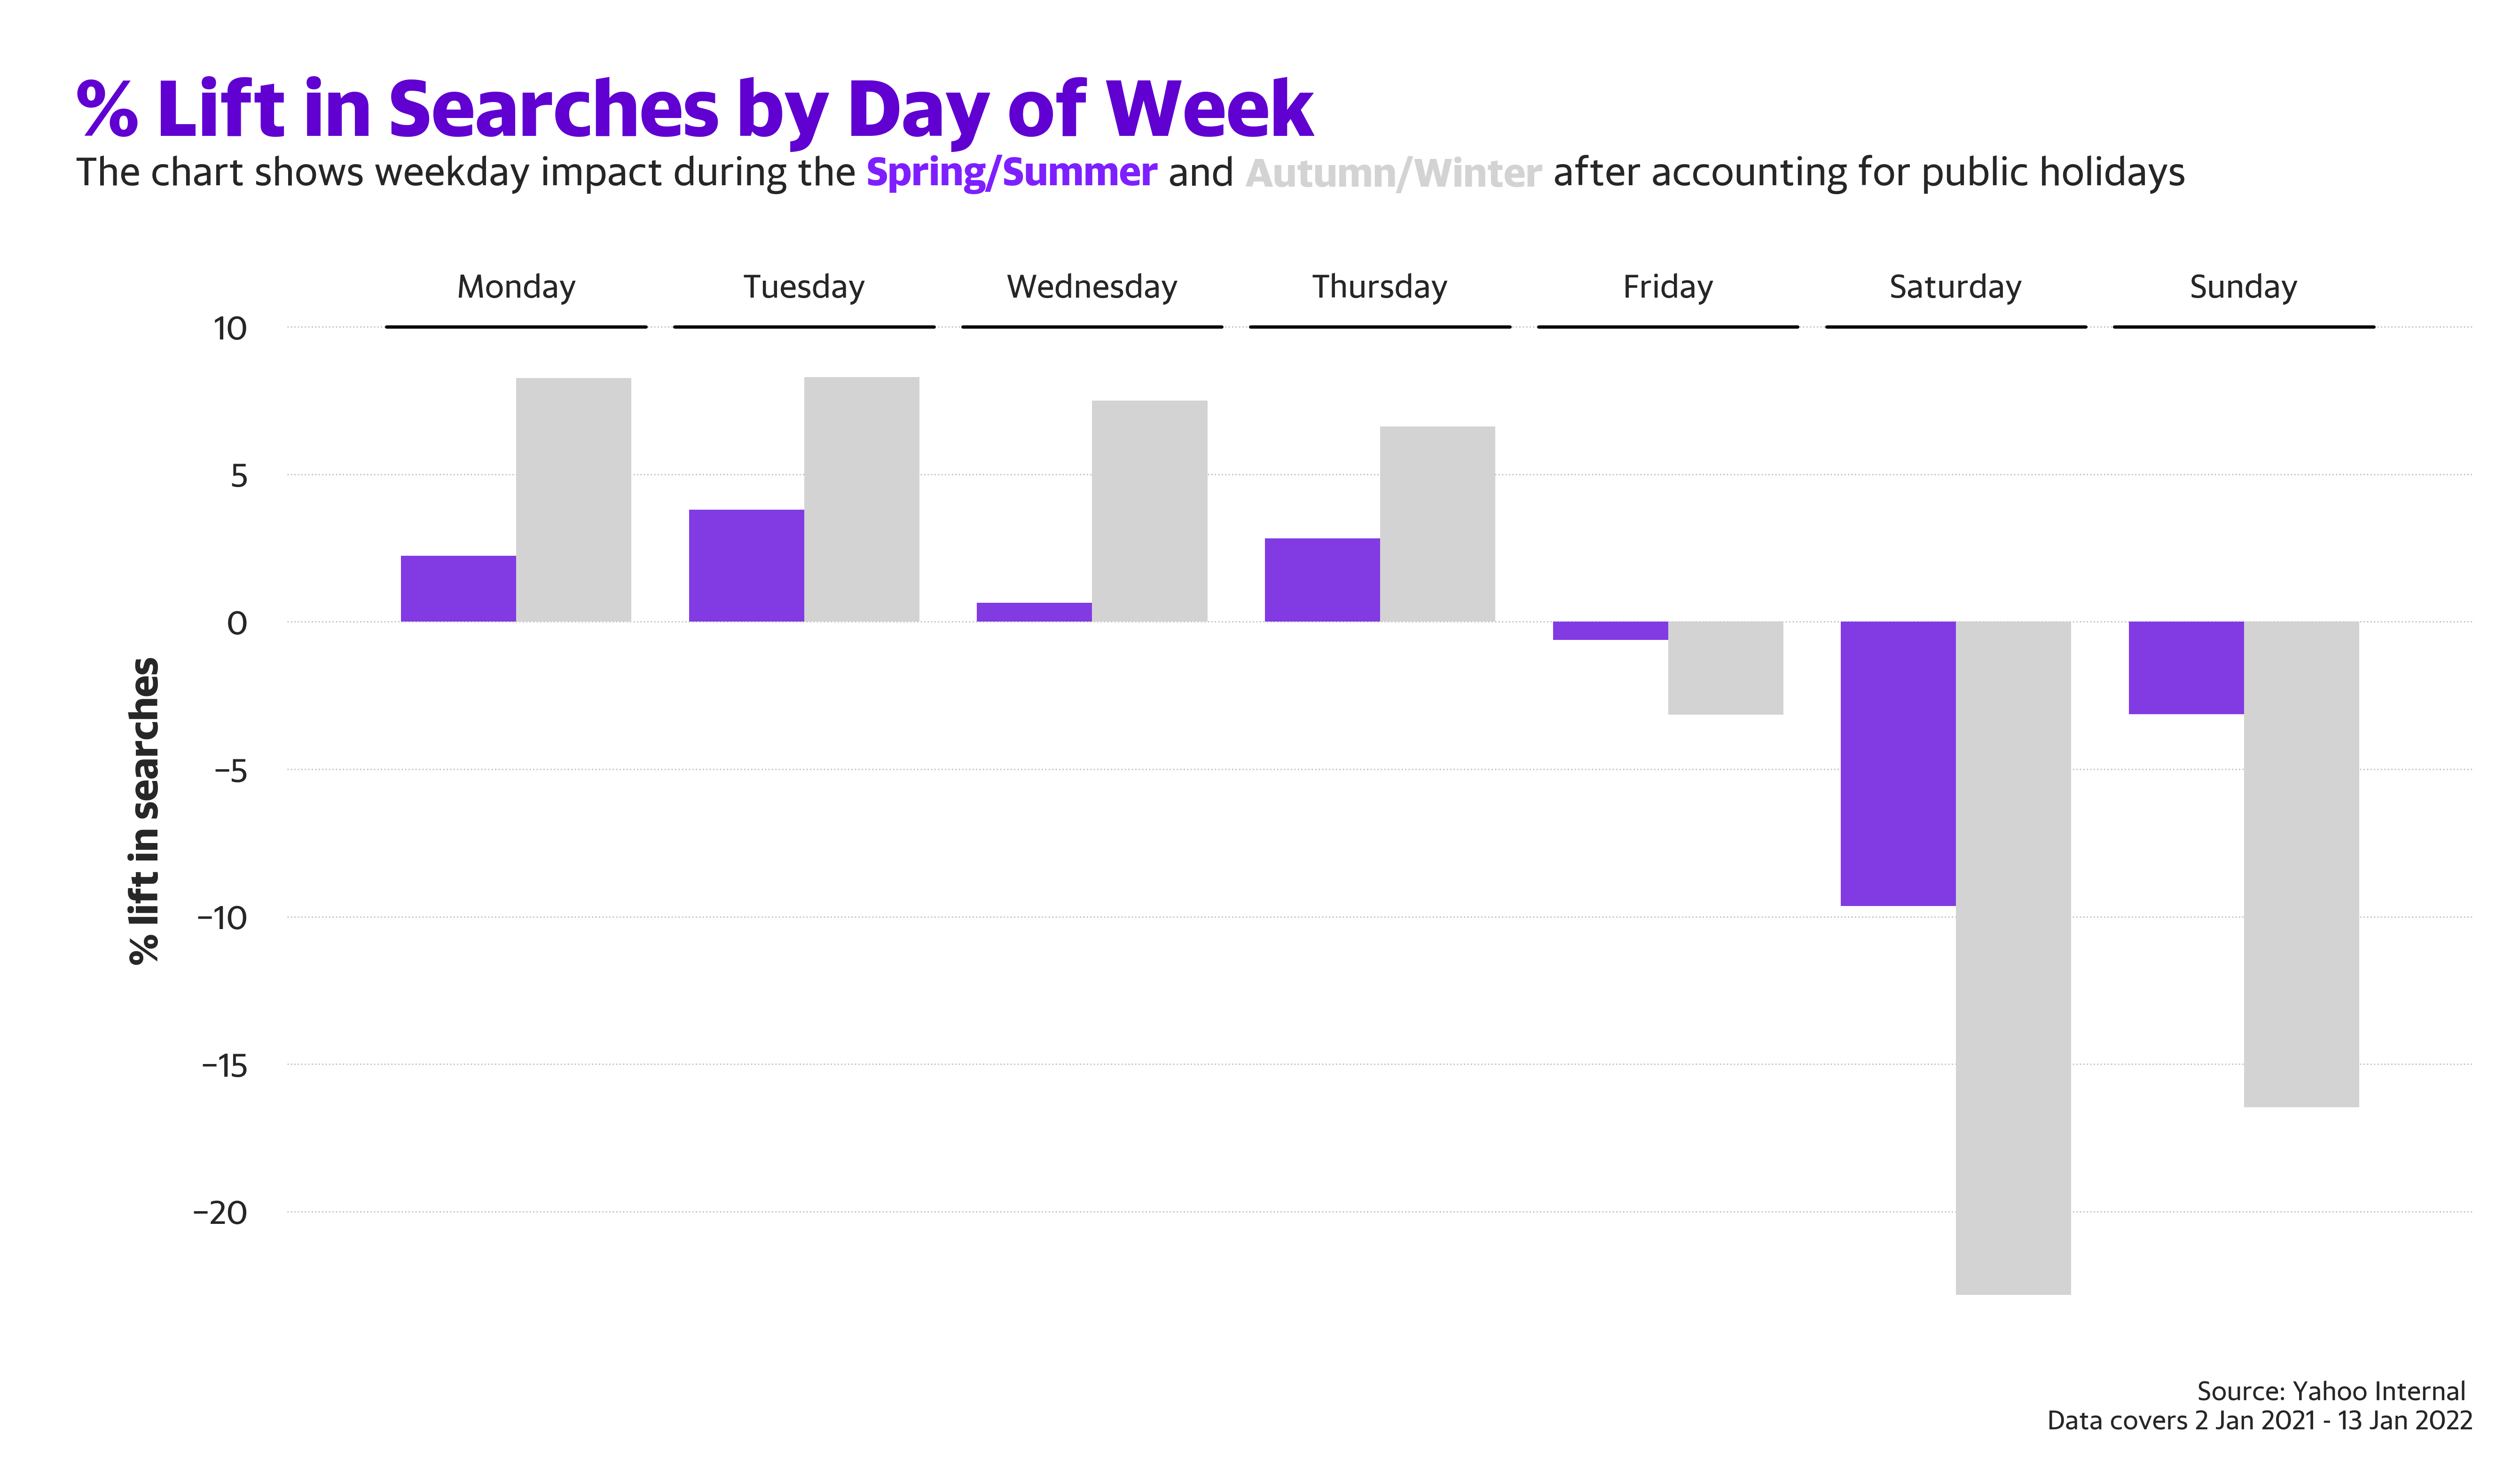

In [312]:
def weekly_impact_plot(df):
        days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        
        weekly_impact = (df_seasonality
                    .groupby('dayofweek')
                    .agg(ss=('weekly_springsummer', 'sum'),
                         aw=('weekly_autumnwinter', 'sum'),
                         pred=('yhat', 'sum'))
                    .reindex(days)
                    .assign(ss_impact=lambda df: df['ss'] / df['pred'] * 100,
                            aw_impact=lambda df: df['aw'] / df['pred'] * 100)
                    .reset_index())
                    
        seasonal_impact = (weekly_impact.melt(id_vars='dayofweek', var_name='season', value_vars=['ss_impact', 'aw_impact'], value_name='impact'))  

        sns.set(font='Yahoo Sans', style='white')
        fig, ax = plt.subplots(figsize=(6,3), dpi=1000)
        sns.barplot(x='dayofweek', y='impact', hue='season', palette=['#7E1FFF', 'lightgrey'], lw=0, ec='black', data=seasonal_impact, ax=ax);

        # Labels
        ax.xaxis.set_ticks_position('top')
        ax.set_xlabel('')
        ax.set_ylabel('% lift in searches', fontsize=6, fontweight='bold')
        ax.tick_params(axis='x', which='both', bottom=False, top=False, left=False, labelsize=5, labeltop=True, pad=-10)
        ax.tick_params(axis='y', which='both', bottom=False, top=False, left=False, labelsize=5, labeltop=True, pad=0)
        yticks = ax.get_yticks()

        # Spines
        sns.despine(left=True, bottom=True)

        for direction in ['bottom', 'left']:
                ax.spines[direction].set_lw(0.2)
                ax.spines[direction].set_color('grey')
                ax.spines[direction].set_alpha(0.5)

        ax.grid(which='major', axis='y', dashes=(1,3), zorder=4, color='gray', ls=':', alpha=0.5, lw=0.2)
        ax.grid(axis='x', visible=False)

        # Title
        s = '% Lift in Searches by Day of Week'
        s2 = 'The chart shows weekday impact during the <Spring/Summer> and <Autumn/Winter> after accounting for public holidays' 
        fig_text(0.05, 0.92, s, fontweight='bold', fontsize=12, va='bottom',  color='#6001D2')

        fig_text(0.05, 0.89, s2, fontsize=6, va='bottom', highlight_textprops=[{"color": "#7E1FFF", "fontweight":'bold'},
                                                                                {"color": "lightgrey", "fontweight":"bold"}])

        
        # Caption
        fig.supxlabel(f'Source: Yahoo Internal \nData covers {research_start} - {research_end}', fontsize=4, x=0.9, ha='right')

        # Custom Grouping Aesthetics
        for day in range(7):
                ax.plot([day - 0.45, day + 0.45], [yticks[-1], yticks[-1]], color='black', lw=0.5)

        ax.get_legend().remove()

        # Adjust axes positions to fit commentary
        pos1 = ax.get_position() # get the original position 
        pos2 = [pos1.x0, pos1.y0 - 0.05,  pos1.width, pos1.height]
        ax.set_position(pos2)

        plt.savefig('weekly_impact.png', dpi=1000, transparent=True)

        return fig

weekly_impact_plot(df_seasonality)